In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import vmo
import vmo.analysis as van
import vmo.analysis.segmentation as vse
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import patches
import librosa

%matplotlib inline

## Load file and extract feature

In [10]:
song_path = '../../shunsuke/audio/flute/Berio - Flute.wav'
sr = 22050
hop_length = 512

y, sr = librosa.load(song_path, sr=sr)
tempo, beat = librosa.beat.beat_track(y, sr=sr)
cqt = librosa.core.cqt(y, sr=sr, hop_length=hop_length)
beat = np.unique(np.concatenate(([0], beat, [cqt.shape[1]])))
cqt_sync = librosa.feature.sync(cqt, beat, aggregate=np.median)
cqt_stack= librosa.feature.stack_memory(cqt_sync, n_steps=3)

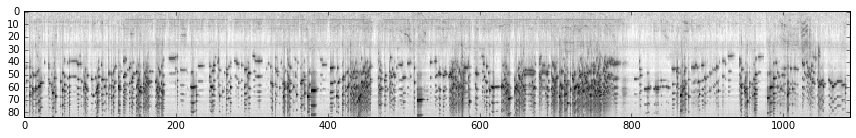

In [11]:
plt.figure(figsize=(12,2))
plt.imshow(librosa.logamplitude(cqt_sync,ref_power=np.max), interpolation='nearest', aspect='auto', cmap='Greys')
plt.tight_layout()

In [16]:
r = (0, 1.01, 0.01)
threshold = vmo.find_threshold(cqt_stack.T, r=r, dim=cqt_stack.shape[0])

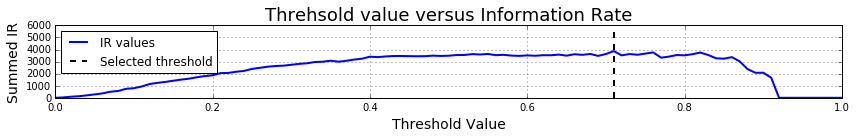

In [17]:
ideal_t = threshold[0][1]
x_t = [i[1] for i in threshold[1]]
y_t = [i[0] for i in threshold[1]]

plt.figure(figsize=(12,2))
plt.plot(x_t, y_t, linewidth = 2)
plt.hold('on')
plt.vlines(ideal_t, 0.0, 6000, colors = 'k',linestyle = 'dashed',linewidth = 2)
plt.grid('on')
plt.legend(['IR values', 'Selected threshold'], loc=2)
plt.title('Threhsold value versus Information Rate', fontsize = 18)
plt.xlabel('Threshold Value',fontsize = 14)
plt.ylabel('Summed IR', fontsize = 14)
plt.tight_layout()


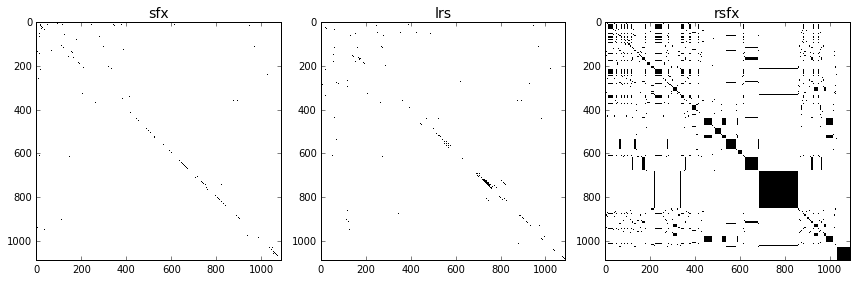

In [21]:
cqt_vmo = vmo.build_oracle(cqt_stack.T, flag='a', threshold=ideal_t, dim=cqt_stack.shape[0])
methods = ['sfx', 'lrs', 'rsfx']

plt.figure(figsize = (12,4))
for i,m in enumerate(methods):
    recurrence_vmo = van.create_selfsim(cqt_vmo, method=m)
    plt.subplot(1,3,i+1)
    plt.imshow(recurrence_vmo, interpolation='nearest', aspect='auto', cmap='Greys')
    plt.title(m, fontsize=14)
plt.tight_layout()

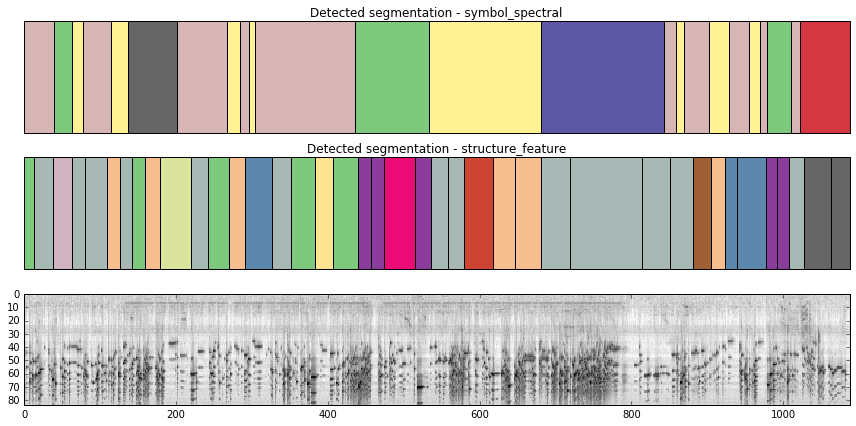

In [30]:
seg_methods = ['symbol_spectral', 'structure_feature']

fig = plt.figure(figsize=(12,6))
for i, method in enumerate(seg_methods):
    
    if method == 'symbol_spectral':
        est_boundaries, est_labels = vse.segmentation(cqt_vmo, method=method, connectivity = 'lrs')        
    else:
        est_boundaries, est_labels = vse.segmentation(cqt_vmo, method=method)
    est_intervals = zip(est_boundaries[:-1],est_boundaries[1:])
    
    ax = fig.add_subplot(3,1,i+1)
    ulabel, invind = np.unique(est_labels, return_inverse=True)
    norm = mpl.colors.Normalize(vmin=np.min(invind), vmax=np.max(invind))
    cmap = cm.get_cmap('Accent')
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    seg = [interval[0] for interval in est_intervals[1:]]
    plt.vlines(seg, 0, 1, linewidth=1)
    for interval, i in zip(est_intervals, invind):
        plt.fill_between([interval[0], interval[1]], 0, 1, color=m.to_rgba(i))
    plt.title('Detected segmentation - '+method)
    plt.xlim(0, est_intervals[-1][1])
    plt.yticks([])
    plt.xticks([])
    
plt.subplot(3,1,3)
plt.imshow(librosa.logamplitude(cqt_sync,ref_power=np.max), interpolation='nearest', aspect='auto', cmap='Greys')
plt.tight_layout()
plt.tight_layout()